# Creating our first Context

## Basics of the basics

In [1]:
import findspark
import pyspark
import time
import operator

In [2]:
from pyspark import SparkConf
from pyspark import SparkContext
findspark.init()

conf = SparkConf()
conf.setMaster("local")
conf.setAppName("spark-basic")
sc = SparkContext(conf = conf)

What does this function do?

In [3]:
def surprise(x):
    for i in range(2,x):
        if (x % i) == 0:
            return(x,"No")
    return(x,"Yes")

In [4]:
def surprise2(x):
    for i in range(2,int((x+2)/2)):
        if (x % i) == 0:
            return(x,"No")
    return(x,"Yes")

In [5]:
rdd = sc.parallelize(range(2,100)).map(surprise2).take(20)

In [6]:
print(rdd)

[(2, 'Yes'), (3, 'Yes'), (4, 'No'), (5, 'Yes'), (6, 'No'), (7, 'Yes'), (8, 'No'), (9, 'No'), (10, 'No'), (11, 'Yes'), (12, 'No'), (13, 'Yes'), (14, 'No'), (15, 'No'), (16, 'No'), (17, 'Yes'), (18, 'No'), (19, 'Yes'), (20, 'No'), (21, 'No')]


#### Warming up Exercise: Smarter way?

**Option 1**

In [50]:
start_time = time.time()

rdd = sc.parallelize(range(2,int(5e2))).map(surprise).take(5)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.026154041290283203 seconds ---


**Option 2**

In [48]:
start_time = time.time()

rdd = sc.parallelize(range(2,int(5e2))).map(surprise2).take(int(5e2))

print("--- %s seconds ---" % (time.time() - start_time))

--- 2.8349945545196533 seconds ---


- What happens if we reduce the value of the function take()?
- What happens if we don't use the function take() ?

## A bit more...

### Persistance

- RDDs in python are lazily evaluated, so if we are planning to reuse multiple times the same RDD, we will be recomputing it that many times
- To avoid this, we can force our program to persist the data

Let's see the persisting approach:

In [51]:
rdd = sc.parallelize(range(2,int(1e3)))
rdd.cache() #Storing (persisting) the object in our memory, in order to not recompute it everytime

start_time = time.time()

rdd.map(surprise).take(100)

print("--- %s seconds ---" % (time.time() - start_time))

--- 7.3238160610198975 seconds ---


Against the normal one:

In [52]:
rdd = sc.parallelize(range(2,int(1e3)))

start_time = time.time()

rdd.map(surprise).take(100)

print("--- %s seconds ---" % (time.time() - start_time))

--- 2.650639057159424 seconds ---


And same happens with the function cache()... What? Why?

### And what about text?

In [11]:
file = open("Quijote.txt","r", encoding='utf-8').read()

In [12]:
rdd = sc.textFile(file)

In [13]:
rdd

PRIMERA PARTE
CAPÍTULO 1: Que trata de la condición y ejercicio del famoso hidalgo D. Quijote de la Mancha
En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua, rocín flaco y galgo corredor. Una olla de algo más vaca que carnero, salpicón las más noches, duelos y quebrantos los sábados, lentejas los viernes, algún palomino de añadidura los domingos, consumían las tres partes de su hacienda. El resto della concluían sayo de velarte, calzas de velludo para las fiestas con sus pantuflos de lo mismo, los días de entre semana se honraba con su vellori de lo más fino. Tenía en su casa una ama que pasaba de los cuarenta, y una sobrina que no llegaba a los veinte, y un mozo de campo y plaza, que así ensillaba el rocín como tomaba la podadera. Frisaba la edad de nuestro hidalgo con los cincuenta años, era de complexión recia, seco de carnes, enjuto de rostro; gran madrugador y amigo 

# More theory... again

## Transformations vs Actions

In a nutshell:

**Transformations** create new rdds\
**Actions** give us values

## Transformations

- Are lazy, really lazy!
- Create dependencies, chains of transformations
- Trigger

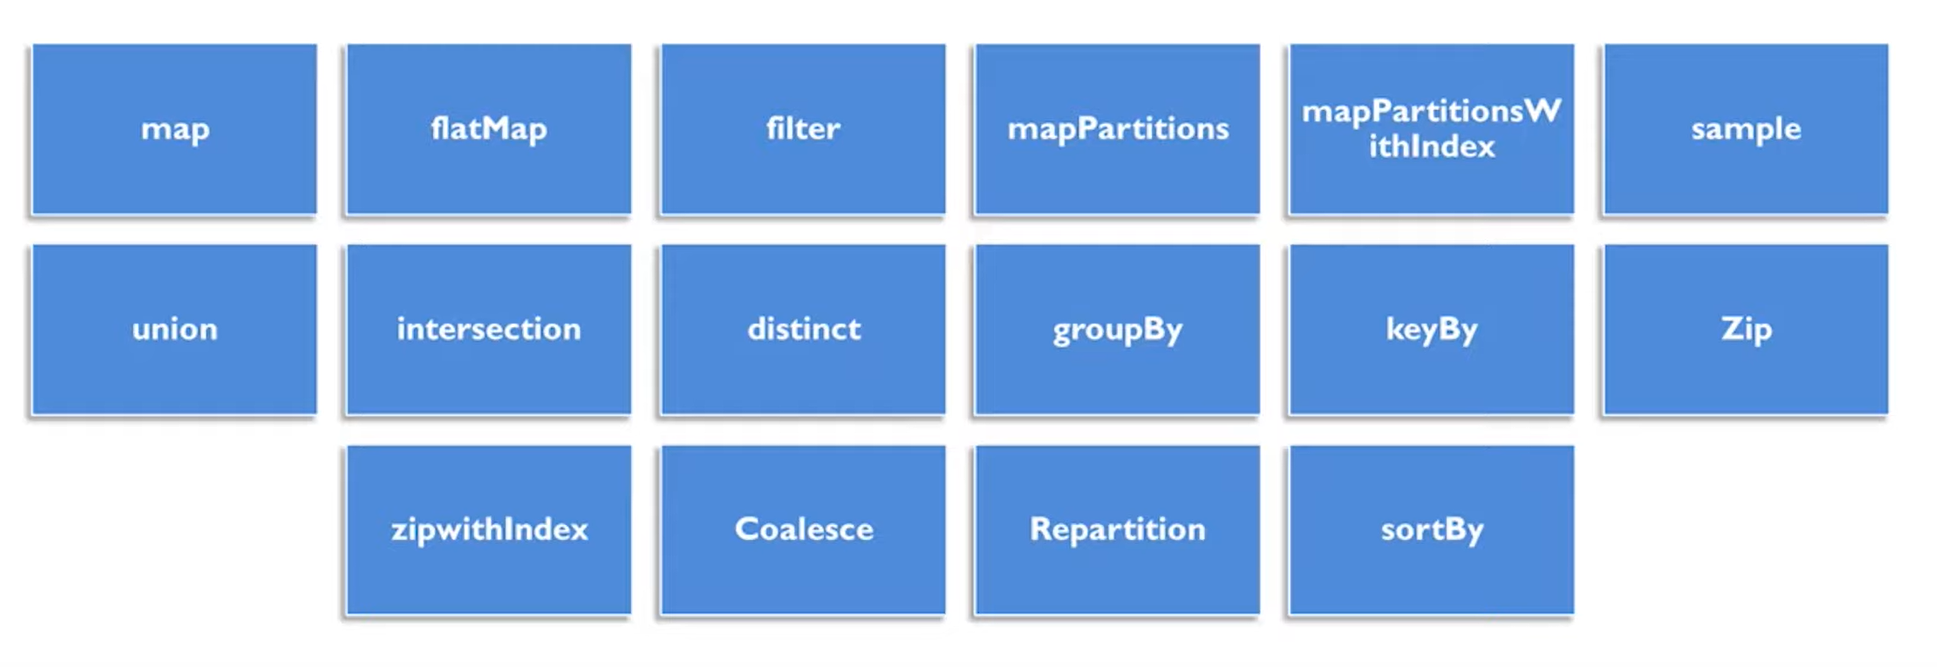

#### Map

In [53]:
x = sc.parallelize(["A","B","C","D","D"])
y = x.map(lambda x:(x,1))
y.collect()

[('A', 1), ('B', 1), ('C', 1), ('D', 1), ('D', 1)]

By the way... collect is not a transformation, but an action!

#### Flatmap

In [56]:
x = sc.parallelize([1,3,4,5])
x.flatMap(lambda x: range(1,x)).collect()

[1, 2, 1, 2, 3, 1, 2, 3, 4]

Try to explain what flatmap does. What is the difference with map? Can you explain what is going on here?

#### Filter

In [16]:
x = sc.parallelize(range(1,20,3))
x.filter(lambda x: x%2 == 0).collect()

[4, 10, 16]

Define a function that, given a list of strings, is able to keep only e-mail adresses.

In [59]:
### Your code here

def findemail(x):
    if x.endswith(".com") and "@" in x:
        return True
    else:
        return False

In [126]:
listofstrings = ["myemail@emai.com","notemail.com", "notemail@email"]

sc.parallelize(listofstrings).filter(findemail).collect()

['myemail@emai.com']

In [127]:
import re

strings = sc.parallelize( ["push123@gmail.com","asdf","jgasull@gmail.com","jgasull@gmail"] )

strings.filter(lambda x: re.findall("([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)", x)).collect()

['push123@gmail.com', 'jgasull@gmail.com']

#### Sample

Search how to use the transformation sample(), which parameters are needed?

Code a function that, using pyspark, returns the sum of k dices of m sides. So dice(k = 3, m = 6) would return values between 3 and 18.

In [130]:
import random

def sumdice(k,m):
    sumdice1 = 0
    for i in range(k):
        sumdice1 += random.randint(1,m)
    return sumdice1

sumdice(3,6)

12

In [125]:
### Your code here

def dice(k, m = 6):
    suma = 0
    for i in range(k):
        suma += sc.parallelize(range(1,m+1)).sample(fraction = 1, withReplacement = True).collect()[0]
    return suma

dice(3)

11

##### Union and intersection

In [19]:
x = sc.parallelize(range(0,10))
y = sc.parallelize(range(6,12))
print(x.union(y).collect())
print(x.intersection(y).collect())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 11]
[6, 8, 7, 9]


Are they symmetric?
Think about a real world application (on social media, for example....) of these two transformations

Code a function that depends of 2 lists, and returns the values that are unique in the first list

In [20]:
#### Your code here

##### Distinct

Explore the transformation distinct, and find a meaningful example where it can be useful

In [11]:
#### Your code here

sc.parallelize([1,3,4,5,4,3,2]).distinct().collect()

[1, 3, 4, 5, 2]

#### Sortby

In [12]:
sc.parallelize([1,3,4,6,2,3,4,5,1]).sortBy(lambda x: x, True ).collect()

[1, 1, 2, 3, 3, 4, 4, 5, 6]

In [16]:
sc.parallelize([("A",5),("B",2),("C",3),("D",1),("D",2)]).sortBy(lambda x: x[1], False ).collect()

[('A', 5), ('C', 3), ('B', 2), ('D', 2), ('D', 1)]

Wait wait... what is it really doing here? Explore a bit!

#### MapPartitions

In [19]:
x = sc.parallelize([1,2,3,4,5],2)
def func(x): yield sum(x)

x.mapPartitions(func).collect()

[3, 12]

What is going on? What are these numbers? Experiment a bit!

Once you have it clear, check the differences between mapPartitions and map PartitionsWithIndex

#### Groupby

In [20]:
x = sc.parallelize([1,1,2,3,4,5,6,8,9])
groups = x.groupBy(lambda x: x % 3).collect()
sorted([ (x,sorted(y)) ] for (x,y) in groups)

[[(0, [3, 6, 9])], [(1, [1, 1, 4])], [(2, [2, 5, 8])]]

In [21]:
groups

[(1, <pyspark.resultiterable.ResultIterable at 0x18441ef2a30>),
 (2, <pyspark.resultiterable.ResultIterable at 0x18441ef2b50>),
 (0, <pyspark.resultiterable.ResultIterable at 0x18441ef2100>)]

Create a function that, given a list of different texts, detects how many times a word(s), appears on it. 

For example, to detect if an article is talking about FCB, check if the words "Messi", "Setien" or "Barça" appear.

In [26]:
#### Your code here

#### Zip

In [27]:
sc.parallelize(range(0,5)).zip(sc.parallelize(range(20,25))).collect()

[(0, 20), (1, 21), (2, 22), (3, 23), (4, 24)]

Does it have any restrictions? What happens if we give different lengths? What would R do?

#### Repartition and coalesce

In [9]:
x = sc.parallelize(range(0,20),6)
x.glom().collect()

[[0, 1, 2],
 [3, 4, 5],
 [6, 7, 8, 9],
 [10, 11, 12],
 [13, 14, 15],
 [16, 17, 18, 19]]

In [11]:
print(x.repartition(2).glom().collect())

print(x.coalesce(2).glom().collect())



[[0, 1, 2, 6, 7, 8, 9, 10, 11, 12], [3, 4, 5, 13, 14, 15, 16, 17, 18, 19]]
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]


What is the criteria? Experiment a little

#### Reduce

In [30]:
from operator import add

sc.parallelize(range(0,100)).reduce(add)


1,2,3,4,5

1, 2       //    3, 4, 5
# add

1+ 2        //   3+4, 5

3          //   7 + 5

3         //    12

3 + 12

15

4950

Why add and not sum?

## Actions

- They produce values back to the Spark program
- They make transformations start moving!

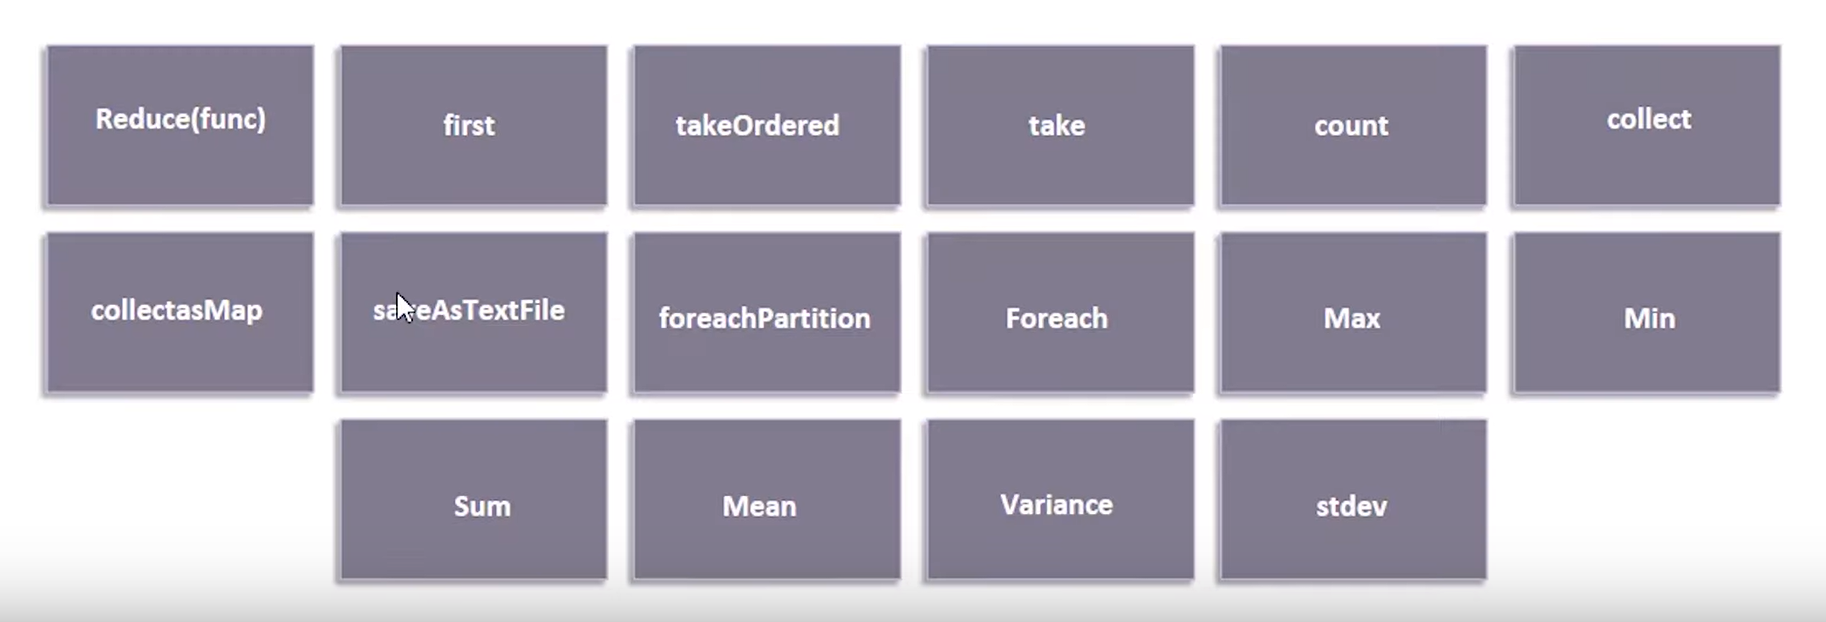

#### Reduce

In [31]:
from operator import add

sc.parallelize(range(0,100)).reduce(add)

4950

Why add and not sum?

Hint:

In [32]:
def prod(a,b):
    return(a*b)

sc.parallelize(range(1,10)).reduce(prod)

362880

#### First and TakeOrdered

In [16]:
x = sc.parallelize([11,1,3,5,4,2,7,8,1,6,5,11])

print(x.first())

print(x.takeOrdered(6))

11
[1, 1, 2, 3, 4, 5]


How would you select the last 3? And the last 3 without repetitions?

In [17]:
x.takeOrdered(6, key=lambda x: -x)


[11, 11, 8, 7, 6, 5]

In [18]:
x.distinct().takeOrdered(6, key=lambda x: -x)


[11, 8, 7, 6, 5, 4]

#### Max, min, sum, mean, variance, stdev, count....

Create a function that computes the coefficient of variation of a numeric list. If you don't know what it is... what better time than now to learn it?!

Create a function that converts a numeric list into a percentage list

In [21]:
#### Your code here

x1= x.stdev()
x2 = x.mean()
x3 = x1/x2
print(x3)

0.618718433538229


In [23]:
# 1, 2, 3     ->    1/6, 2/6, 3/6 (in % form)
from operator import add
totalsum = x.reduce(add) # x.sum()
x2 = x.map(lambda x:(x/totalsum * 100))
x2.collect()

[0.171875,
 0.015625,
 0.046875,
 0.078125,
 0.0625,
 0.03125,
 0.109375,
 0.125,
 0.015625,
 0.09375,
 0.078125,
 0.171875]

#### Countbyvalue

In [35]:
sc.parallelize([1,2,5,4,6,8,7,2,3,4,3,1,6,7,3,2,1]).countByValue()

defaultdict(int, {1: 3, 2: 3, 5: 1, 4: 2, 6: 2, 8: 1, 7: 2, 3: 3})

## Some functions and more transformations (with paired RDDs)

#### Reducebykey and groupByKey

In [31]:
x = sc.parallelize({(1,2),(2,1),(1,3),(3,3),(4,1)})
print(x.reduceByKey(add).collect())
x.groupByKey().collect()

[(1, 5), (2, 1), (4, 1), (3, 3)]


[(1, <pyspark.resultiterable.ResultIterable at 0x1cccc9c8970>),
 (2, <pyspark.resultiterable.ResultIterable at 0x1cccc8eefa0>),
 (4, <pyspark.resultiterable.ResultIterable at 0x1cccc8eef40>),
 (3, <pyspark.resultiterable.ResultIterable at 0x1cccc9b86a0>)]

In [33]:
x.groupByKey().mapValues(list).collect()

[(1, [2, 3]), (2, [1]), (4, [1]), (3, [3])]

Describe and code a real world application with these functions. Try to incorporate other actions/transformations to make it more meaningful

In [37]:
#### Your code here

#### mapValues and flatMapValues

Explore how these two transformations work, and find a working example for them

In [34]:
#### Your code here

x = sc.parallelize([("a", ["apple", "banana", "lemon"]), ("b", ["grapes"])])
x.mapValues(lambda f : len(f)).collect()


[('a', 3), ('b', 1)]

In [38]:
x = sc.parallelize([("a", ["apple", "banana", "lemon"]), ("b", ["grapes"])])
x.flatMapValues(lambda x: x).collect()


['a', ['apple', 'banana', 'lemon'], 'b', ['grapes']]

#### Keys, sortByKey and substractByKey

In [40]:
x = sc.parallelize({(1,2),(2,1),(1,3),(3,3),(4,1)})
x.keys().collect()

[1, 2, 4, 3, 1]

In [41]:
x.sortByKey().collect()

[(1, 2), (1, 3), (2, 1), (3, 3), (4, 1)]

In [42]:
y = sc.parallelize({(1,2),(5,3)})
x.subtractByKey(y).collect()

[(2, 1), (4, 1), (3, 3)]

#### Joins!!!

Explore the transformations .join(), .rightOuterJoin(), .leftOuterJoin() and .cogroup()

Work with the following data:

In [3]:
x = sc.parallelize({("A",2),("B",1),("A",3),("C",3),("D",1)})
y = sc.parallelize({("D",1),("A",7),("B",3),("A",9),("E",3),("F",4)})

In [5]:
#### Your code here

x.join(y).collect()

[('B', (1, 3)),
 ('A', (2, 9)),
 ('A', (2, 7)),
 ('A', (3, 9)),
 ('A', (3, 7)),
 ('D', (1, 1))]

In [6]:
x.rightOuterJoin(y).collect()

[('B', (1, 3)),
 ('A', (2, 9)),
 ('A', (2, 7)),
 ('A', (3, 9)),
 ('A', (3, 7)),
 ('D', (1, 1)),
 ('F', (None, 4)),
 ('E', (None, 3))]

In [8]:
x.cogroup(y).collect()

[('C',
  (<pyspark.resultiterable.ResultIterable at 0x2323bf4f670>,
   <pyspark.resultiterable.ResultIterable at 0x2323bfb77c0>)),
 ('B',
  (<pyspark.resultiterable.ResultIterable at 0x2323bfb7640>,
   <pyspark.resultiterable.ResultIterable at 0x2323bfb7760>)),
 ('A',
  (<pyspark.resultiterable.ResultIterable at 0x2323bfb7940>,
   <pyspark.resultiterable.ResultIterable at 0x2323bfb78e0>)),
 ('D',
  (<pyspark.resultiterable.ResultIterable at 0x2323bfb79a0>,
   <pyspark.resultiterable.ResultIterable at 0x2323bfb79d0>)),
 ('F',
  (<pyspark.resultiterable.ResultIterable at 0x2323bfb7a90>,
   <pyspark.resultiterable.ResultIterable at 0x2323bfb7af0>)),
 ('E',
  (<pyspark.resultiterable.ResultIterable at 0x2323bfb7b80>,
   <pyspark.resultiterable.ResultIterable at 0x2323bfb7b50>))]

### Exercise

Code a word count program that gives you the top 100 words of "El Quijote". The order you perform the operations is really important here!

In [44]:
#### Your code here

List of hints:
- First try to split the words before transforming them into a rdd
- You need to assign each of the words a value 1, we have seen how to do it
- After that, you will need to use the word (the key) to sum the 1s
- Almost done, but we would like to see the top... is the dictionary in the right order?

#### One possible solution... don't look!
Explain line by line what is going on!

In [45]:
import re

file = open("Quijote.txt","r", encoding='utf-8').read()
words = file.split(" ")
words = sc.parallelize(words)
# words = words.map(lambda x: re.sub(r'[^\w\s]','',x)) # Try it with and without this line
wordcount = words.map(lambda x: (x,1)) 
wordcount = wordcount.reduceByKey(add) # Alternatively wordcount.reduceByKey(lambda x,y: x+y)
wordcount = wordcount.map(lambda x: (x[1],x[0]))
wordcount.sortByKey(False).take(50)

[(9583, 'que'),
 (7636, 'de'),
 (7085, 'y'),
 (4300, 'la'),
 (4167, 'a'),
 (3905, 'el'),
 (3384, 'en'),
 (2536, 'no'),
 (2247, 'se'),
 (1763, 'con'),
 (1762, 'los'),
 (1690, 'por'),
 (1631, 'su'),
 (1613, 'le'),
 (1562, 'lo'),
 (1234, 'las'),
 (1078, 'como'),
 (1055, 'me'),
 (1009, 'del'),
 (979, 'mas'),
 (932, 'mi'),
 (903, 'si'),
 (895, 'es'),
 (785, 'yo'),
 (754, 'un'),
 (705, 'al'),
 (688, 'dijo'),
 (660, 'Quijote'),
 (657, 'tan'),
 (656, 'porque'),
 (622, 'para'),
 (606, 'habia'),
 (572, 'Sancho'),
 (570, 'don'),
 (555, 'sin'),
 (515, 'una'),
 (510, 'ni'),
 (489, 'todo'),
 (465, 'o'),
 (454, 'bien'),
 (447, 'era'),
 (441, 'esta'),
 (432, 'ser'),
 (425, 'asi'),
 (419, 'sus'),
 (410, 'esto'),
 (393, 'ha'),
 (392, 'respondio'),
 (388, 'vuestra'),
 (381, 'cual')]

### Another Exercise!

Let's code a shopping list!
We will have a list of elements like this:
    
x = sc.parallelize([["Apple",3,0.2],["Pear",5,0.35],["Milk",2,1.1],["Apple",3,0.2]])

Where the first element of each list is the product, the second the number of unit we bought and the third the unit price.

We want to have the list of how much we have spent in each product (ordered), and the total amount of money we have spent. 

(Optional) If we buy more than 10 products of the same type, we have a 10% discount of the final price

In [46]:
x = sc.parallelize([["Apple",3,0.2],["Pear",5,0.35],["Milk",2,1.1],["Apple",3,0.2]])

### Last one...

Replicate the last exercise, but the structure of the data is different. We have one object with products and prices. On the other hand, we have one list of the following form:

x = sc.parallelize([["Maria","Apple",1],["Maria","Pear",2],["Pau","Milk",4],["Laura","Apple",3]])

We want to know how much each of the have spent in total.

In [47]:
#### Your code here

In [48]:
sc._jsc.sc().uiWebUrl().get()

'http://MAD-SURF002.netmind.local:4040'